In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import pickle

import sys
from pathlib import Path
# Add the parent directory to the system path
sys.path.append(str(Path().resolve().parent))

from causal_meta_learners.causal_inference_modeling import *
from causal_meta_learners.experiment_setup import *
from causal_meta_learners.survival_models import *

# Load Data

In [2]:
with open('../data_splits/mental-health-full/people_dict_unfiltered_expanded.pickle', 'rb') as handle:
    people_dict = pickle.load(handle)


data_df = pd.read_csv('../data_generation/adherence_export_expanded.csv')
data_df

,mci_uniq_id,relative_ym,race_common_desc,ethnic_common_desc,legal_sex_common_desc,ed_lvl_common_desc,non_covered_days,covered_by_injectable,covered_by,age,ind_302,ind_jail,ind_death,predicted_PRO_MORTALITY_12MO,predicted_PRO_JAILSTAY_12MO,predicted_PRO_OVERDOSE_12MO,predicted_PRO_302_12MO,predicted_PRO_SHELTER_STAY_12MO
0,06104d172d8be267d6333c60ae480426,0.0,2~Black/African American,2~Not Hispanic/Latinx,1~Male,UNDERGRAD~Some College,0.000000,0,olanzapine,48,0,0,0,0.005327,0.022756,0.000653,0.003653,0.021936
1,06104d172d8be267d6333c60ae480426,1.0,2~Black/African American,2~Not Hispanic/Latinx,1~Male,UNDERGRAD~Some College,0.000000,0,olanzapine,48,0,0,0,0.005327,0.022756,0.000653,0.003653,0.021936
2,06104d172d8be267d6333c60ae480426,2.0,2~Black/African American,2~Not Hispanic/Latinx,1~Male,UNDERGRAD~Some College,0.419355,0,olanzapine,48,0,0,0,0.005327,0.022756,0.000653,0.003653,0.021936
3,06104d172d8be267d6333c60ae480426,3.0,2~Black/African American,2~Not Hispanic/Latinx,1~Male,UNDERGRAD~Some College,1.000000,0,NaN,48,0,0,0,0.006181,0.058112,0.001167,0.003778,0.023075
4,06104d172d8be267d6333c60ae480426,4.0,2~Black/African American,2~Not Hispanic/Latinx,1~Male,UNDERGRAD~Some College,1.000000,0,NaN,49,0,0,0,0.006629,0.073386,0.001299,0.004542,0.039367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466400,5b892d32a4cb9d39d4aa4936539415b9,2.0,1~White,2~Not Hispanic/Latinx,1~Male,99~Unknown,0.000000,0,"risperidone,haloperidol",25,0,0,0,0.002813,0.003732,0.000628,0.002818,0.005360
466401,5b892d32a4cb9d39d4aa4936539415b9,3.0,1~White,2~Not Hispanic/Latinx,1~Male,99~Unknown,0.166667,0,"risperidone,haloperidol",25,0,0,0,0.002411,0.004547,0.000392,0.003012,0.005389
466402,5b892d32a4cb9d39d4aa4936539415b9,4.0,1~White,2~Not Hispanic/Latinx,1~Male,99~Unknown,1.000000,0,NaN,25,0,0,0,0.005960,0.006138,0.000711,0.003100,0.004079
466403,5b892d32a4cb9d39d4aa4936539415b9,5.0,1~White,2~Not Hispanic/Latinx,1~Male,99~Unknown,1.000000,0,NaN,25,0,0,0,0.003770,0.006161,0.000513,0.003667,0.005981


## Setup Data (Any First Event)

In [3]:
HORIZON = 12 # months
NON_ADHERENCE_THRESHOLD = 1./3
MINIMUM_NUM_TIME_STEPS = 4
LOW_OCCURENCY_THRESHOLD = 2
EXPERIMENT_TASK = "survival"
EXPERIMENT_TYPE = "Composite Event"
EXPERIMENT_NUM = "SA"

In [4]:
continuous_covariates_lst=['age', 'covered_by_injectable', 
                           'predicted_PRO_MORTALITY_12MO', 'predicted_PRO_JAILSTAY_12MO', 'predicted_PRO_OVERDOSE_12MO',
                           'predicted_PRO_302_12MO', 'predicted_PRO_SHELTER_STAY_12MO']

In [5]:
patient_data = PatientData(people_dict, data_df, 
                           experiment_type=EXPERIMENT_TYPE,
                           task=EXPERIMENT_TASK, horizon=HORIZON, 
                           non_adherence_threshold=NON_ADHERENCE_THRESHOLD, 
                           minimum_num_time_steps=MINIMUM_NUM_TIME_STEPS, 
                           low_occurrency_threshold=LOW_OCCURENCY_THRESHOLD,
                           continuous_covariates_lst=continuous_covariates_lst)

# Causal Inference Baselines

## Experiment Setup "SA":  $\bigg(\big(\underline{X_{Demographics}, f(\bar{A}_{T-1}), X^{Scores}_{T}}, \underline{A_T}\big), (\underline{Y,\delta})\bigg)$ 
### where $f(\bar{A}_{T-1})=[A_{1},...,A_{T-1}]$ and $X^{Scores}_T = [S_T^{\text{12-mo Mortality}}, S_T^{\text{12-mo Jail}}, S_T^{\text{12-mo 302}}, S_T^{\text{12-mo Shelter}}, S_T^{\text{12-mo Overdose}}]$

In [7]:
causal_data_dict = patient_data.get_causal_data_setup_for_each_experiment(EXPERIMENT_NUM)

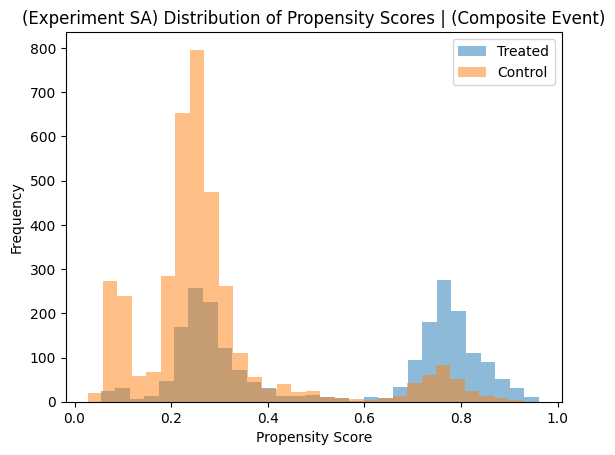

/home/snoroozi/anaconda3/envs/surv_kernet/lib/python3.9/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]
/home/snoroozi/anaconda3/envs/surv_kernet/lib/python3.9/site-packages/causalinference/estimators/weighting.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  wlscoef = np.linalg.lstsq(Z_w, Y_w)[0]


In [8]:
plot_positivity_check(causal_data_dict, EXPERIMENT_NUM, EXPERIMENT_TYPE, verbose=False)

#### ATE estimators from Meta Learners and Matching

Running Causal Inference with CoxPH ...
Running t-learner ...
Running s-learner ...
Running matching (K=1) ...
Running matching (K=2) ...
Running matching (K=5) ...
Running matching (K=10) ...
Running matching (K=20) ...
Running matching (K=50) ...
Running matching (K=100) ...


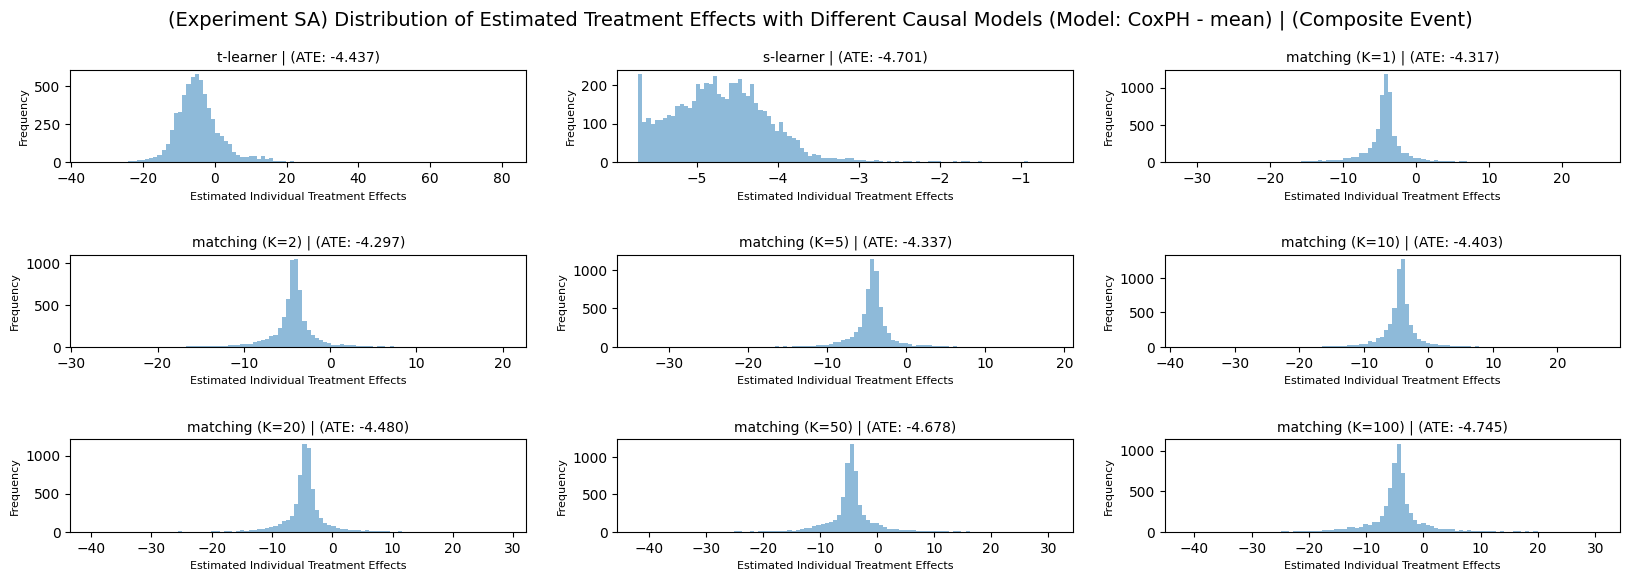

Running Causal Inference with RandomSurvivalForest ...
Running t-learner ...
Running s-learner ...
Running matching (K=1) ...
Running matching (K=2) ...
Running matching (K=5) ...
Running matching (K=10) ...
Running matching (K=20) ...
Running matching (K=50) ...
Running matching (K=100) ...


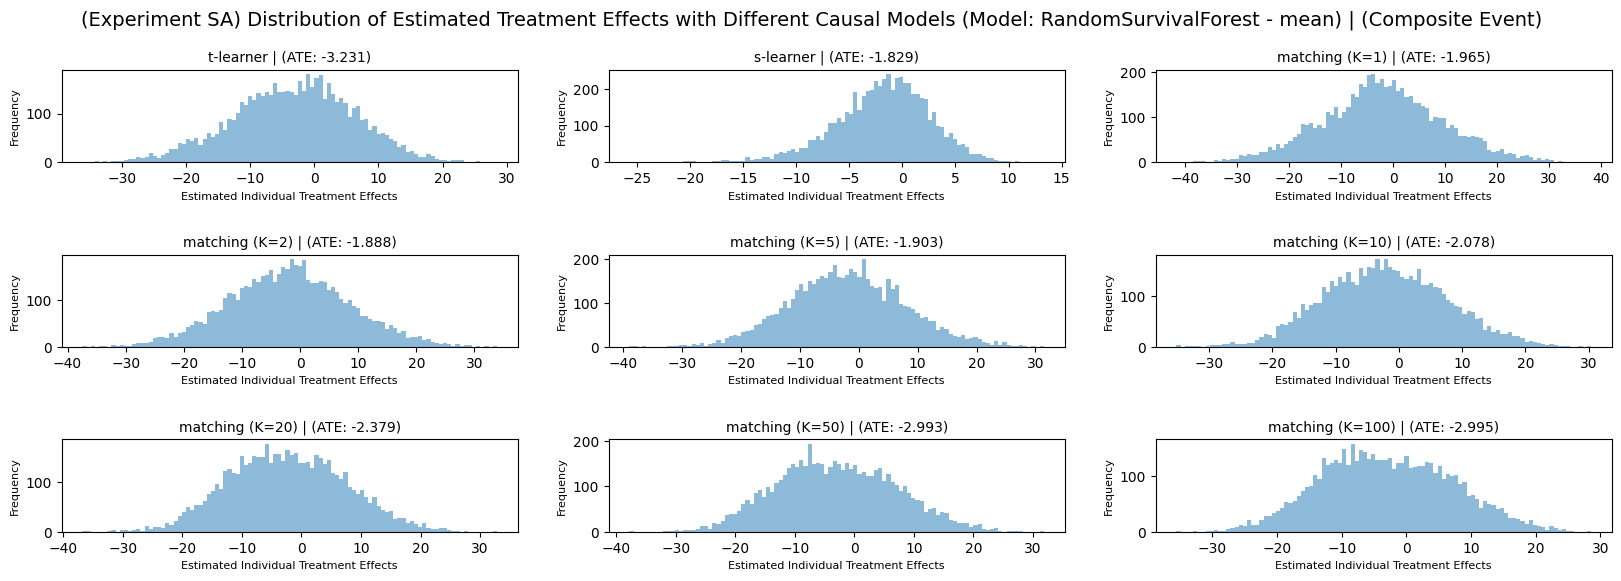

Running Causal Inference with DeepSurv ...
Running t-learner ...
Running s-learner ...
Running matching (K=1) ...
Running matching (K=2) ...
Running matching (K=5) ...
Running matching (K=10) ...
Running matching (K=20) ...
Running matching (K=50) ...
Running matching (K=100) ...


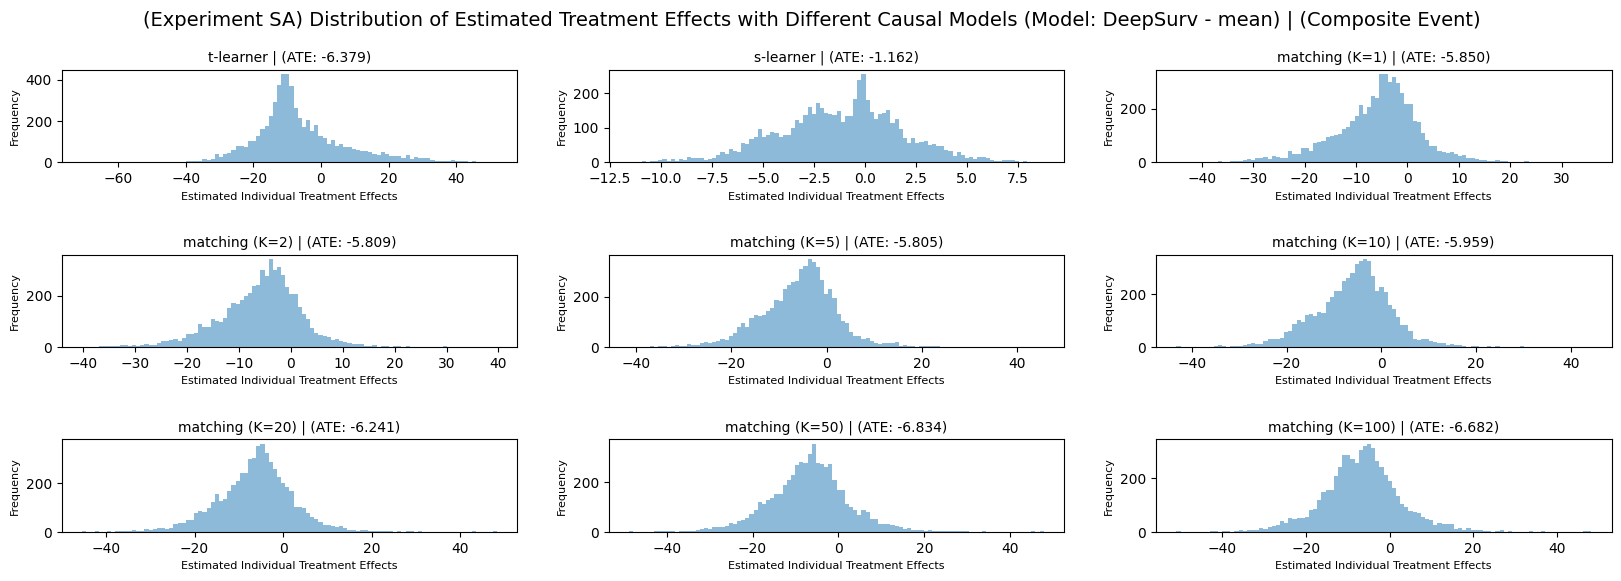

Running Causal Inference with DeepHit ...
Running t-learner ...
Running s-learner ...
Running matching (K=1) ...
Running matching (K=2) ...
Running matching (K=5) ...
Running matching (K=10) ...
Running matching (K=20) ...
Running matching (K=50) ...
Running matching (K=100) ...


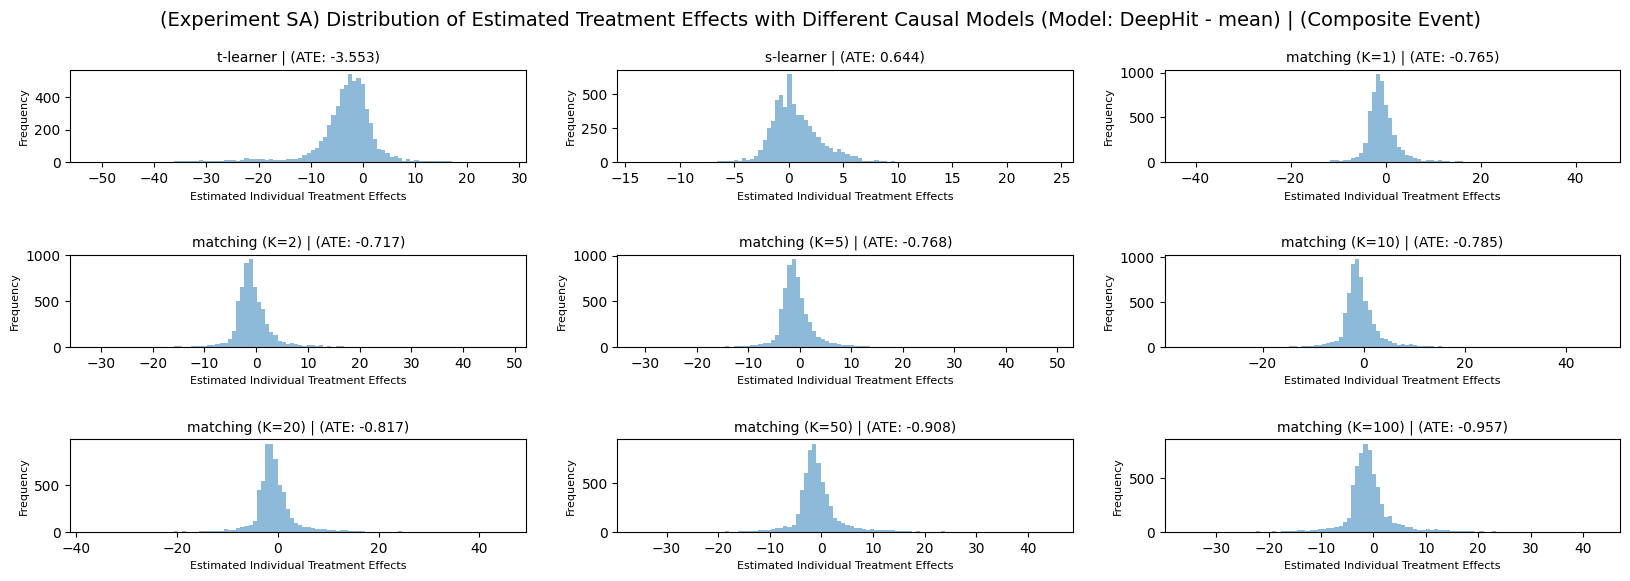

In [9]:
ML_models = [{"CoxPH": {}}, {"RandomSurvivalForest": {}}, {"DeepSurv": {}}, {"DeepHit": {}}]
handle_imbalance = True
num_matches_list = [1, 2, 5, 10, 20, 50, 100]

for ML_model in ML_models:
    print(f"Running Causal Inference with {list(ML_model.keys())[0]} ...")
    get_meta_learner_results(causal_data_dict, ML_model, handle_imbalance, ['t-learner', 's-learner', 'matching'], num_matches_list, 
                            EXPERIMENT_NUM, EXPERIMENT_TYPE, 
                            task=EXPERIMENT_TASK, task_setup_dict={"metric": "mean", "max_time": np.inf, "extrapolate_median": True},
                            is_trimmed=False, plot_results=True, print_results=False, verbose_output=False);
    print("="*100)

Running Causal Inference with CoxPH ...
Running t-learner ...
Running s-learner ...
Running matching (K=1) ...
Running matching (K=2) ...
Running matching (K=5) ...
Running matching (K=10) ...
Running matching (K=20) ...
Running matching (K=50) ...
Running matching (K=100) ...


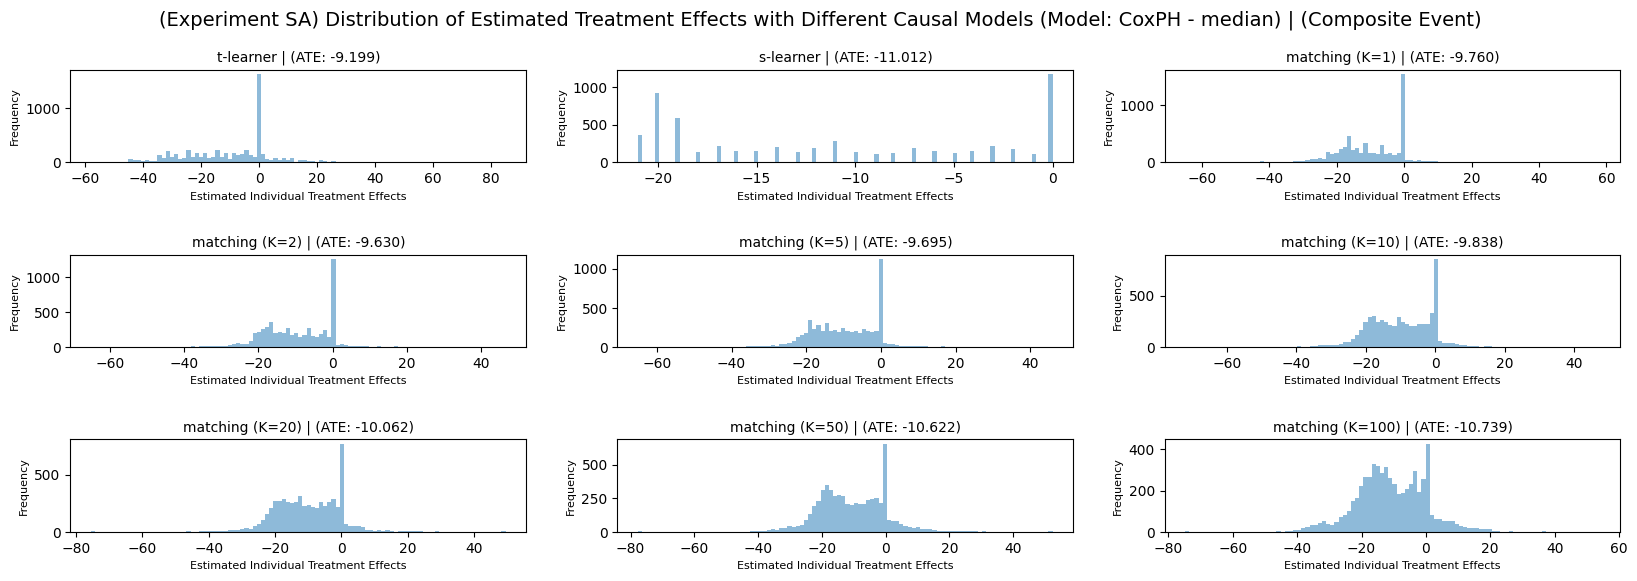

Running Causal Inference with RandomSurvivalForest ...
Running t-learner ...
Running s-learner ...
Running matching (K=1) ...
Running matching (K=2) ...
Running matching (K=5) ...
Running matching (K=10) ...
Running matching (K=20) ...
Running matching (K=50) ...
Running matching (K=100) ...


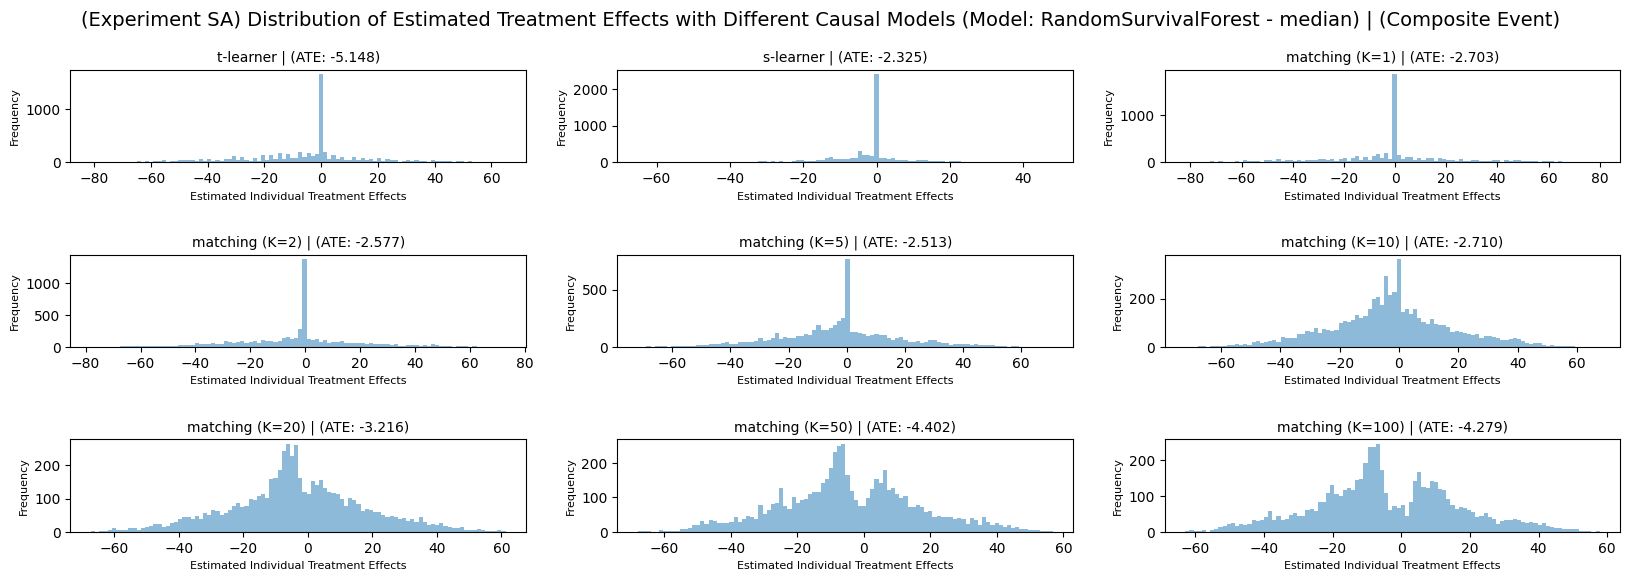

Running Causal Inference with DeepSurv ...
Running t-learner ...
Running s-learner ...
Running matching (K=1) ...
Running matching (K=2) ...
Running matching (K=5) ...
Running matching (K=10) ...
Running matching (K=20) ...
Running matching (K=50) ...
Running matching (K=100) ...


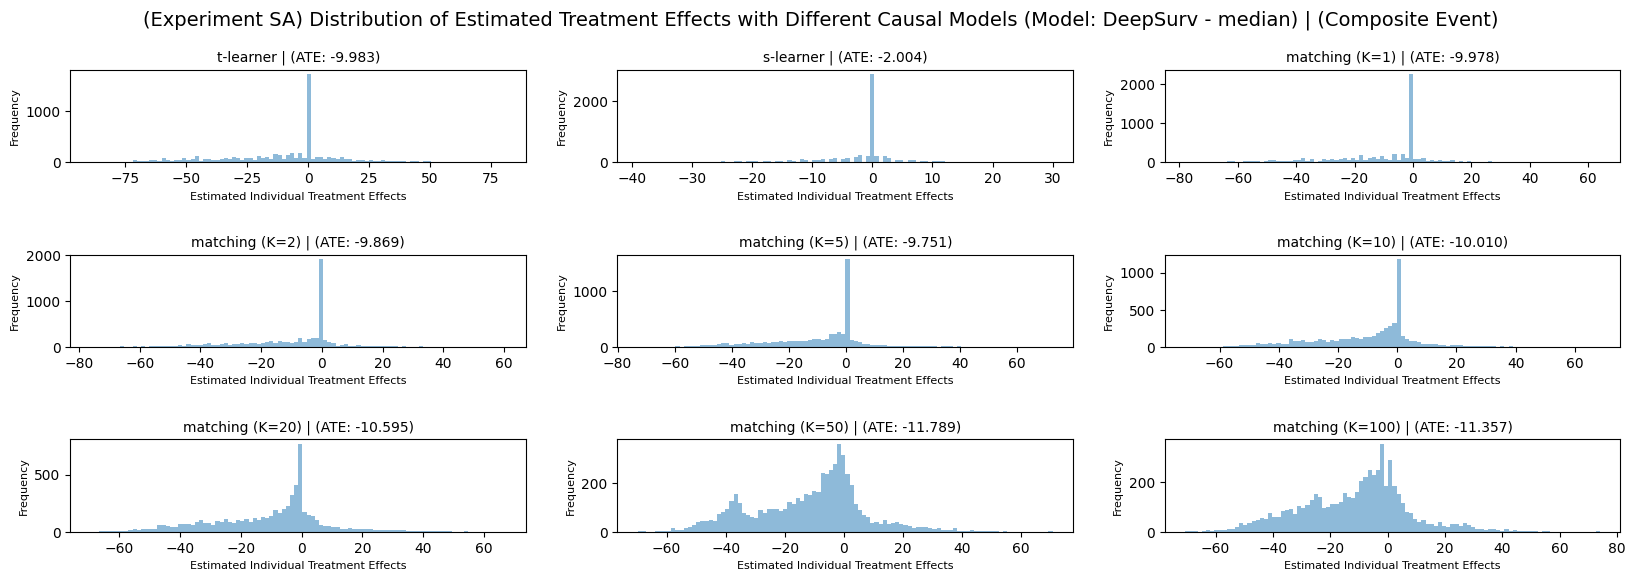

Running Causal Inference with DeepHit ...
Running t-learner ...
Running s-learner ...
Running matching (K=1) ...
Running matching (K=2) ...
Running matching (K=5) ...
Running matching (K=10) ...
Running matching (K=20) ...
Running matching (K=50) ...
Running matching (K=100) ...


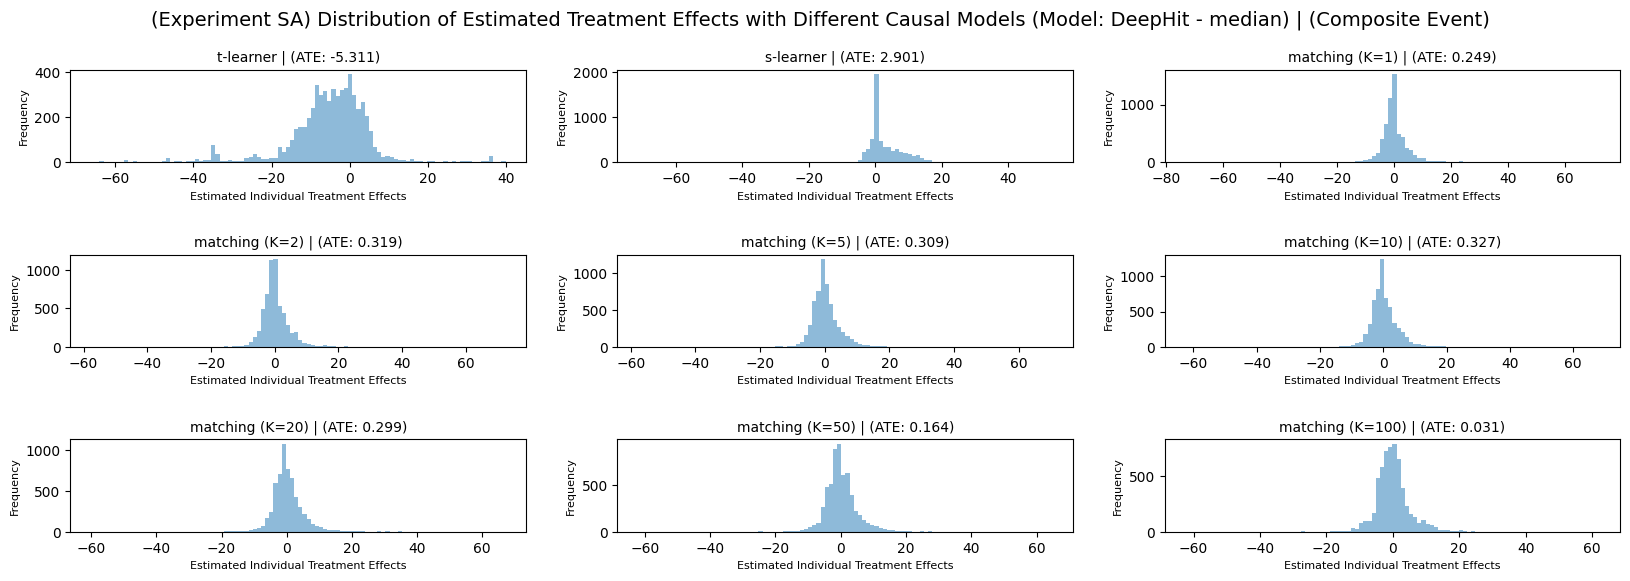

In [10]:
ML_models = [{"CoxPH": {}}, {"RandomSurvivalForest": {}}, {"DeepSurv": {}}, {"DeepHit": {}}]
handle_imbalance = True
num_matches_list = [1, 2, 5, 10, 20, 50, 100]

for ML_model in ML_models:
    print(f"Running Causal Inference with {list(ML_model.keys())[0]} ...")
    get_meta_learner_results(causal_data_dict, ML_model, handle_imbalance, ['t-learner', 's-learner', 'matching'], num_matches_list, 
                            EXPERIMENT_NUM, EXPERIMENT_TYPE, 
                            task=EXPERIMENT_TASK, task_setup_dict={"metric": "median", "max_time": np.inf, "extrapolate_median": True},
                            is_trimmed=False, plot_results=True, print_results=False, verbose_output=False);
    print("="*100)

#### Adjust Positivity Assumption through Trimming

Number of always treated row combinations: 23
Number of always control row combinations: 18
Total rows: 5951
Rows always treated: 58
Rows always control: 35
Filtered rows: 5858
Number of columns before filtering: 23
Number of columns after filtering: 23
Original split row index: 4760
New split row index: 4680


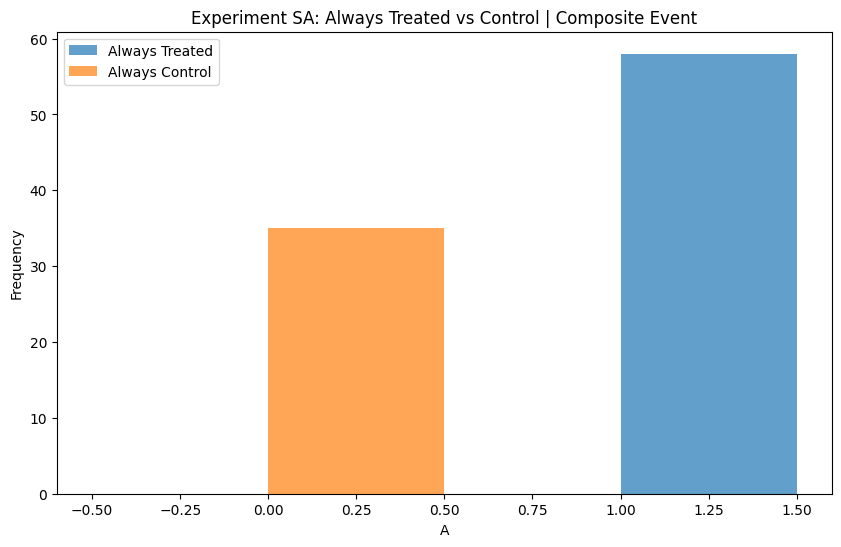

In [9]:
causal_data_dict_trimmed = patient_data.adjust_data_for_positivity(causal_data_dict, EXPERIMENT_NUM, exclude_continuous=True, verbose_output=True)

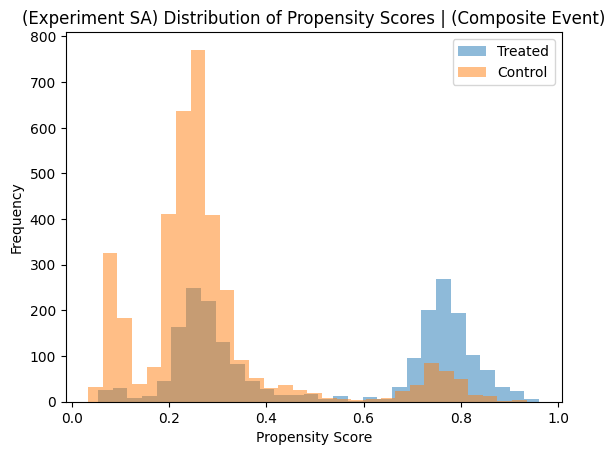

/home/snoroozi/anaconda3/envs/surv_kernet/lib/python3.9/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]
/home/snoroozi/anaconda3/envs/surv_kernet/lib/python3.9/site-packages/causalinference/estimators/weighting.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  wlscoef = np.linalg.lstsq(Z_w, Y_w)[0]


In [10]:
plot_positivity_check(causal_data_dict_trimmed, EXPERIMENT_NUM, EXPERIMENT_TYPE, verbose=False)

#### [Trimmed] ATE estimators from Meta Learners and Matching

Running Causal Inference with CoxPH ...
Running t-learner ...
Running s-learner ...
Running matching (K=1) ...
Running matching (K=2) ...
Running matching (K=5) ...
Running matching (K=10) ...
Running matching (K=20) ...
Running matching (K=50) ...
Running matching (K=100) ...


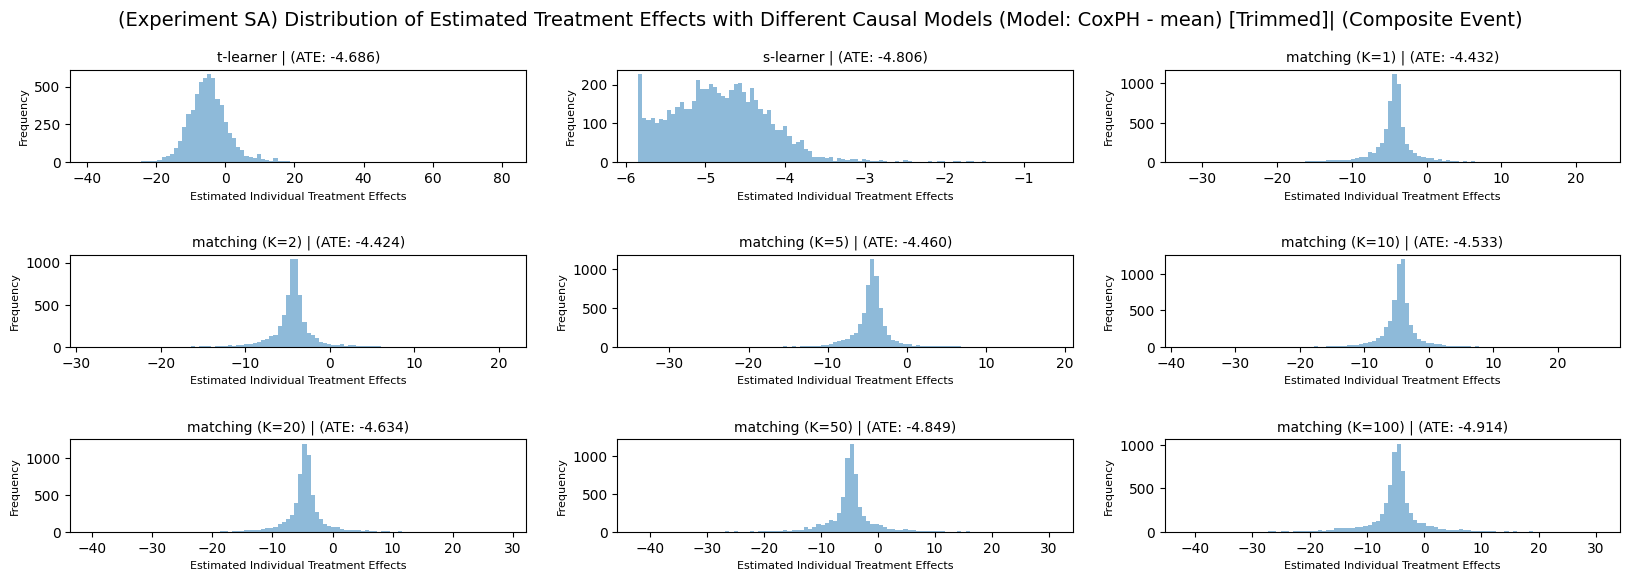

Running Causal Inference with RandomSurvivalForest ...
Running t-learner ...
Running s-learner ...
Running matching (K=1) ...
Running matching (K=2) ...
Running matching (K=5) ...
Running matching (K=10) ...
Running matching (K=20) ...
Running matching (K=50) ...
Running matching (K=100) ...


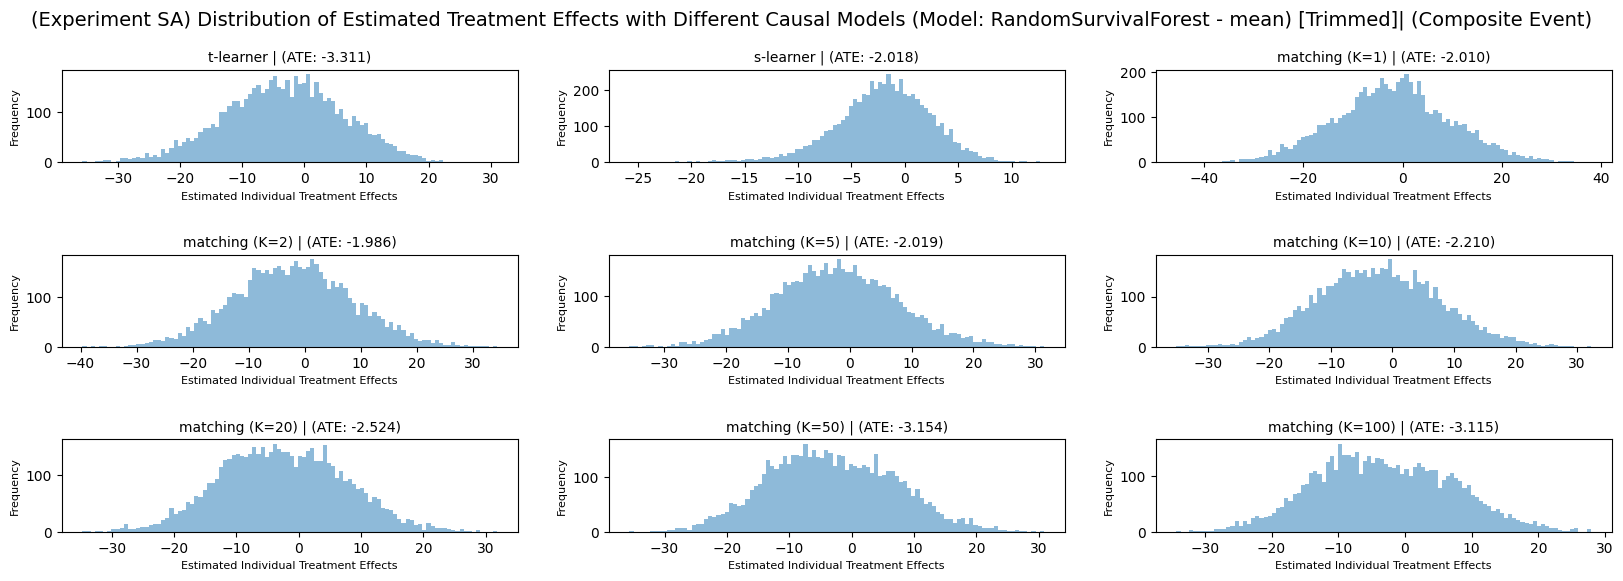

Running Causal Inference with DeepSurv ...
Running t-learner ...
Running s-learner ...
Running matching (K=1) ...
Running matching (K=2) ...
Running matching (K=5) ...
Running matching (K=10) ...
Running matching (K=20) ...
Running matching (K=50) ...
Running matching (K=100) ...


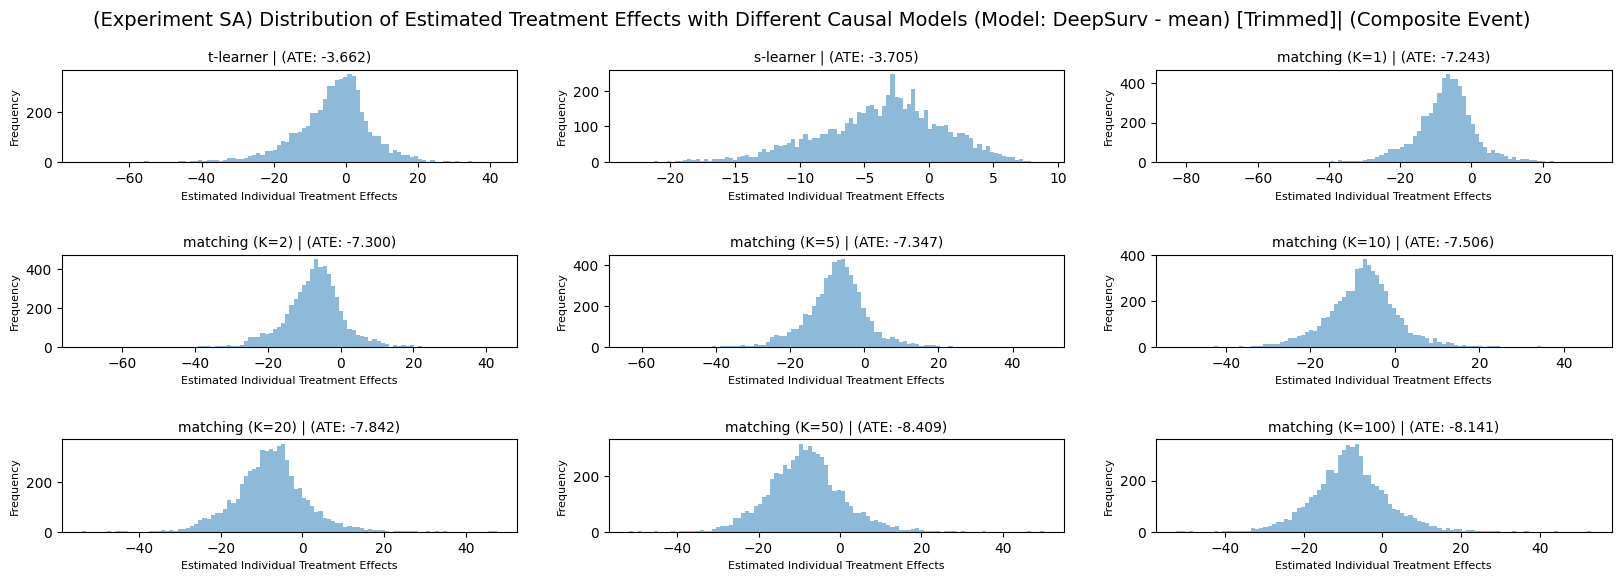

Running Causal Inference with DeepHit ...
Running t-learner ...
Running s-learner ...
Running matching (K=1) ...
Running matching (K=2) ...
Running matching (K=5) ...
Running matching (K=10) ...
Running matching (K=20) ...
Running matching (K=50) ...
Running matching (K=100) ...


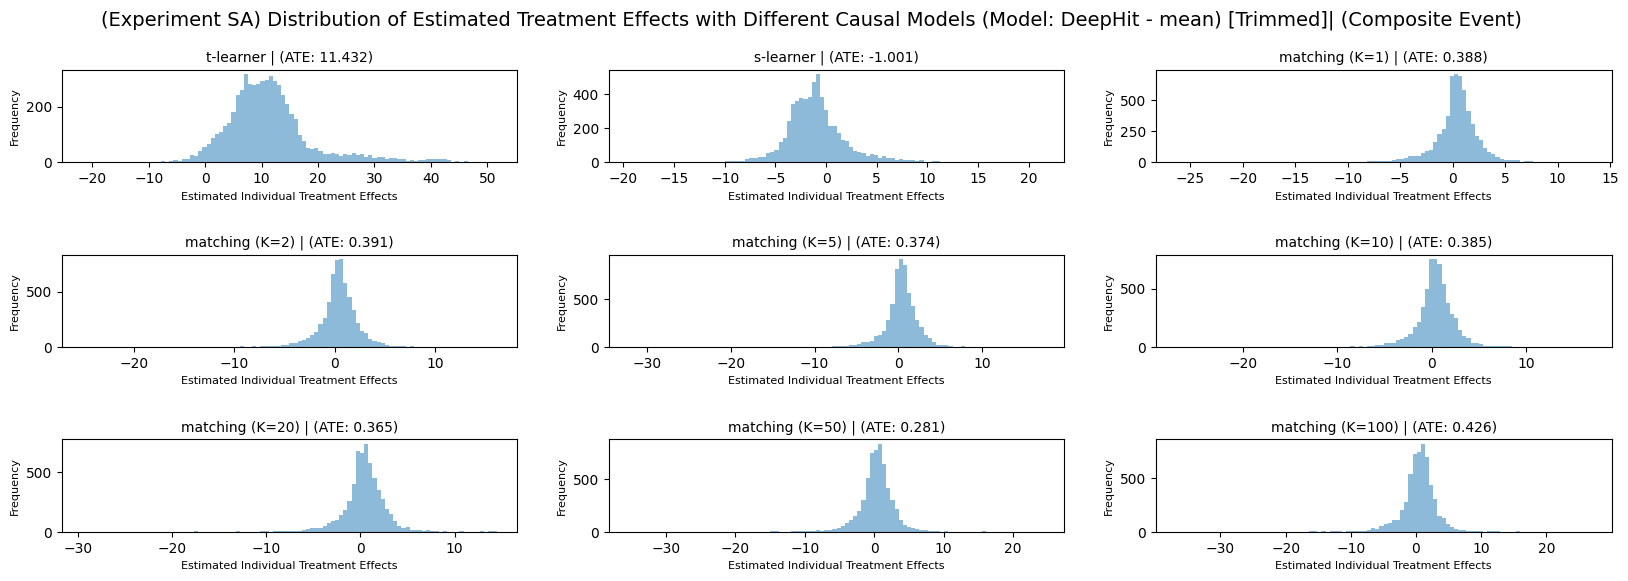

In [13]:
ML_models = [{"CoxPH": {}}, {"RandomSurvivalForest": {}}, {"DeepSurv": {}}, {"DeepHit": {}}]
handle_imbalance = True
num_matches_list = [1, 2, 5, 10, 20, 50, 100]

for ML_model in ML_models:
    print(f"Running Causal Inference with {list(ML_model.keys())[0]} ...")
    get_meta_learner_results(causal_data_dict_trimmed, ML_model, handle_imbalance, ['t-learner', 's-learner', 'matching'], num_matches_list, 
                            EXPERIMENT_NUM, EXPERIMENT_TYPE, 
                            task=EXPERIMENT_TASK, task_setup_dict={"metric": "mean", "max_time": np.inf, "extrapolate_median": True},
                            is_trimmed=True, plot_results=True, print_results=False, verbose_output=False);
    print("="*100)

Running Causal Inference with CoxPH ...
Running t-learner ...
Running s-learner ...
Running matching (K=1) ...
Running matching (K=2) ...
Running matching (K=5) ...
Running matching (K=10) ...
Running matching (K=20) ...
Running matching (K=50) ...
Running matching (K=100) ...


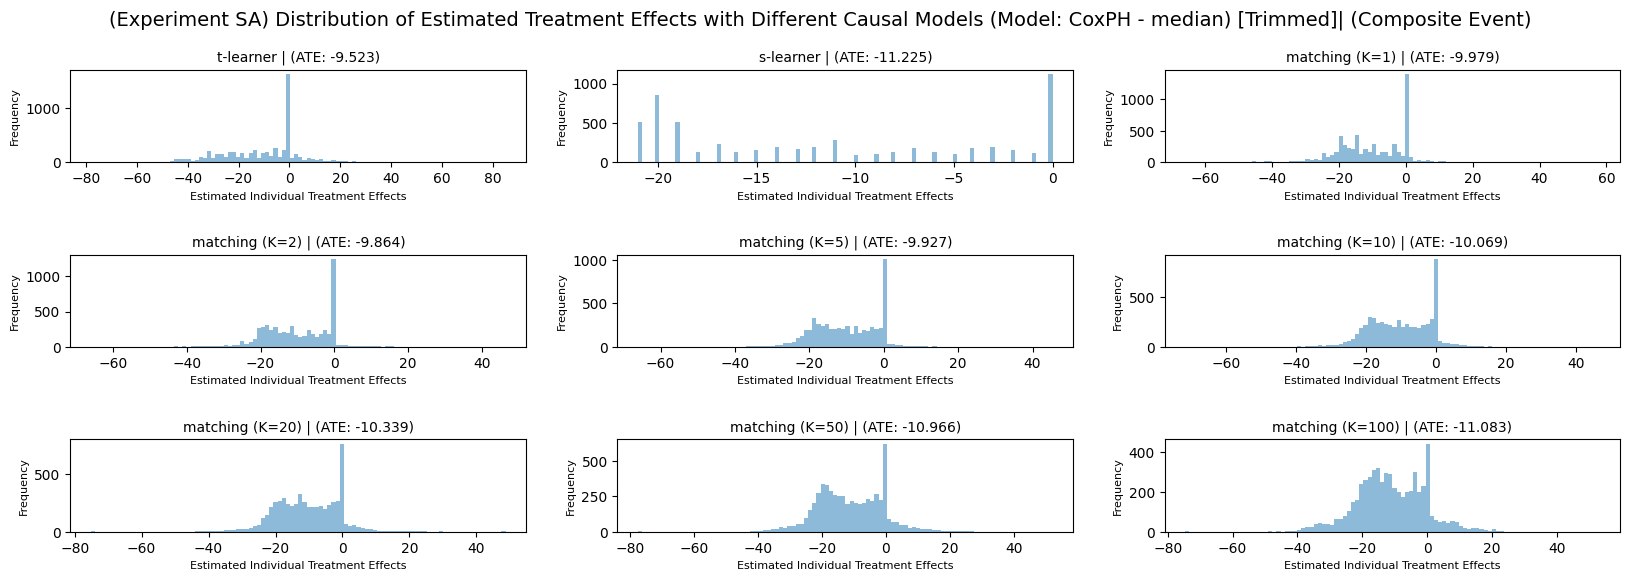

Running Causal Inference with RandomSurvivalForest ...
Running t-learner ...
Running s-learner ...
Running matching (K=1) ...
Running matching (K=2) ...
Running matching (K=5) ...
Running matching (K=10) ...
Running matching (K=20) ...
Running matching (K=50) ...
Running matching (K=100) ...


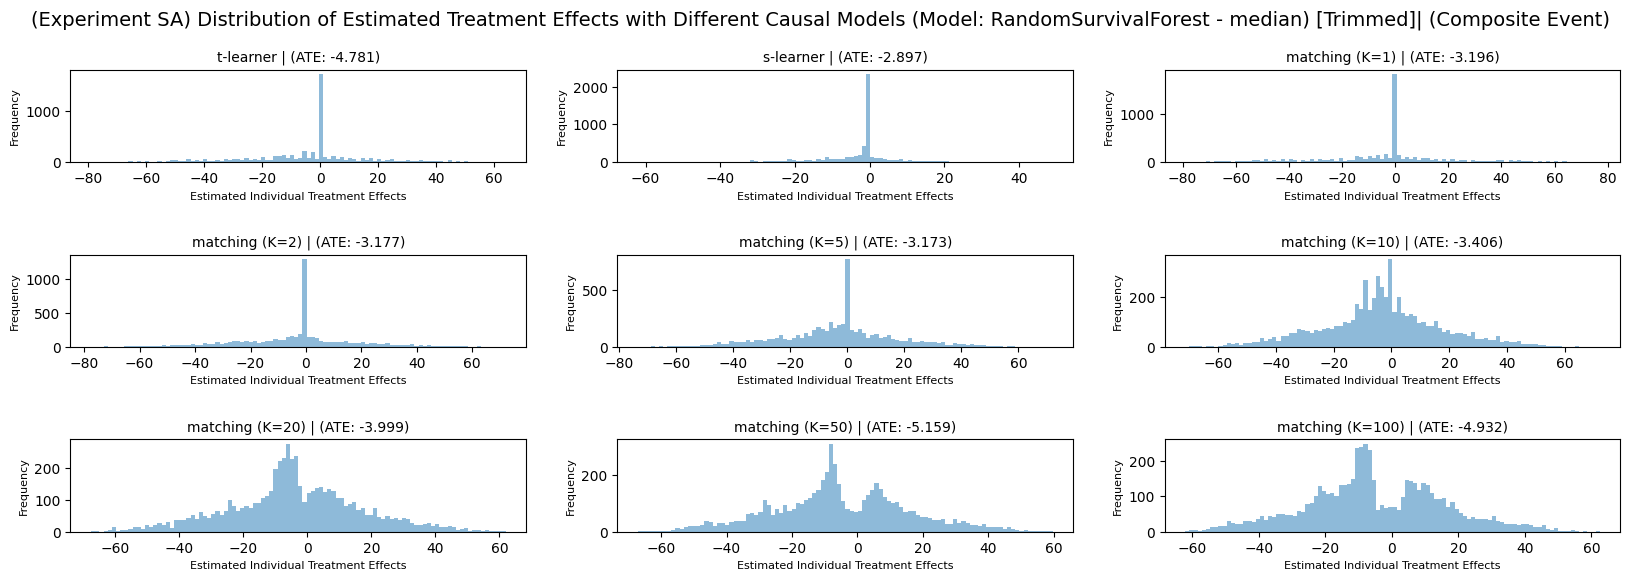

Running Causal Inference with DeepSurv ...
Running t-learner ...
Running s-learner ...
Running matching (K=1) ...
Running matching (K=2) ...
Running matching (K=5) ...
Running matching (K=10) ...
Running matching (K=20) ...
Running matching (K=50) ...
Running matching (K=100) ...


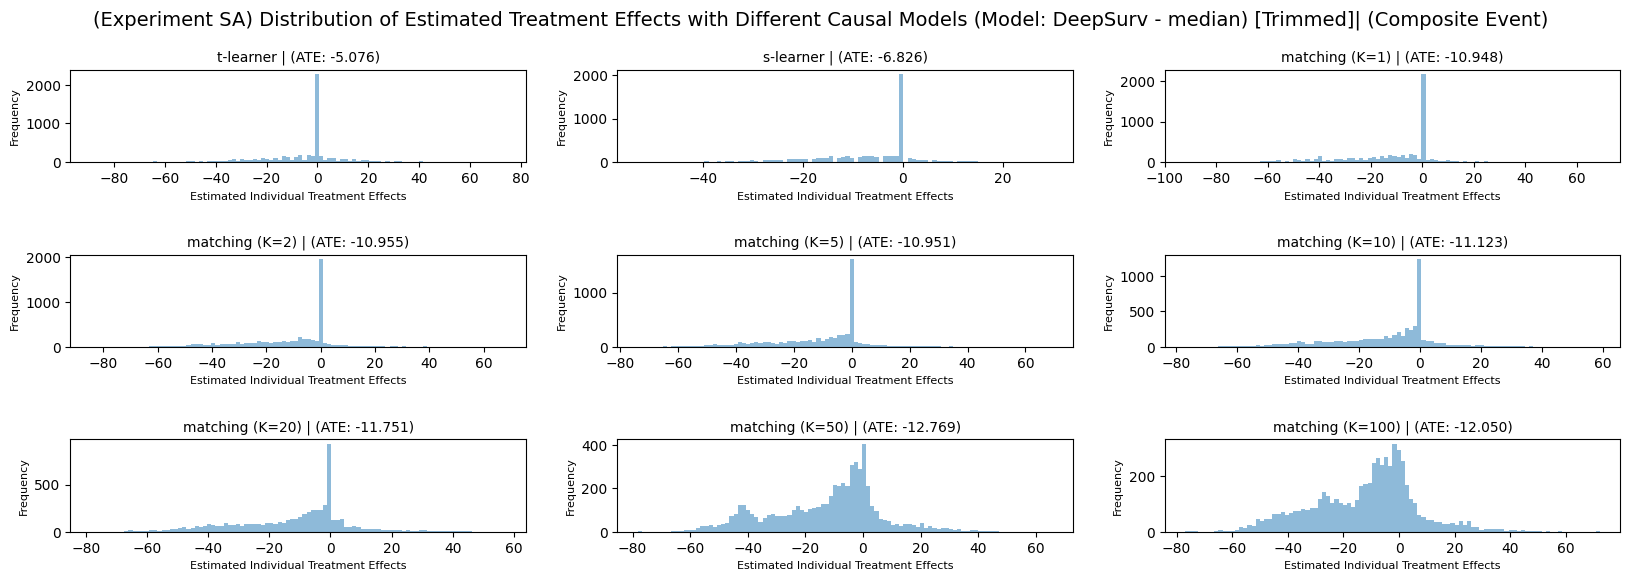

Running Causal Inference with DeepHit ...
Running t-learner ...
Running s-learner ...
Running matching (K=1) ...
Running matching (K=2) ...
Running matching (K=5) ...
Running matching (K=10) ...
Running matching (K=20) ...
Running matching (K=50) ...
Running matching (K=100) ...


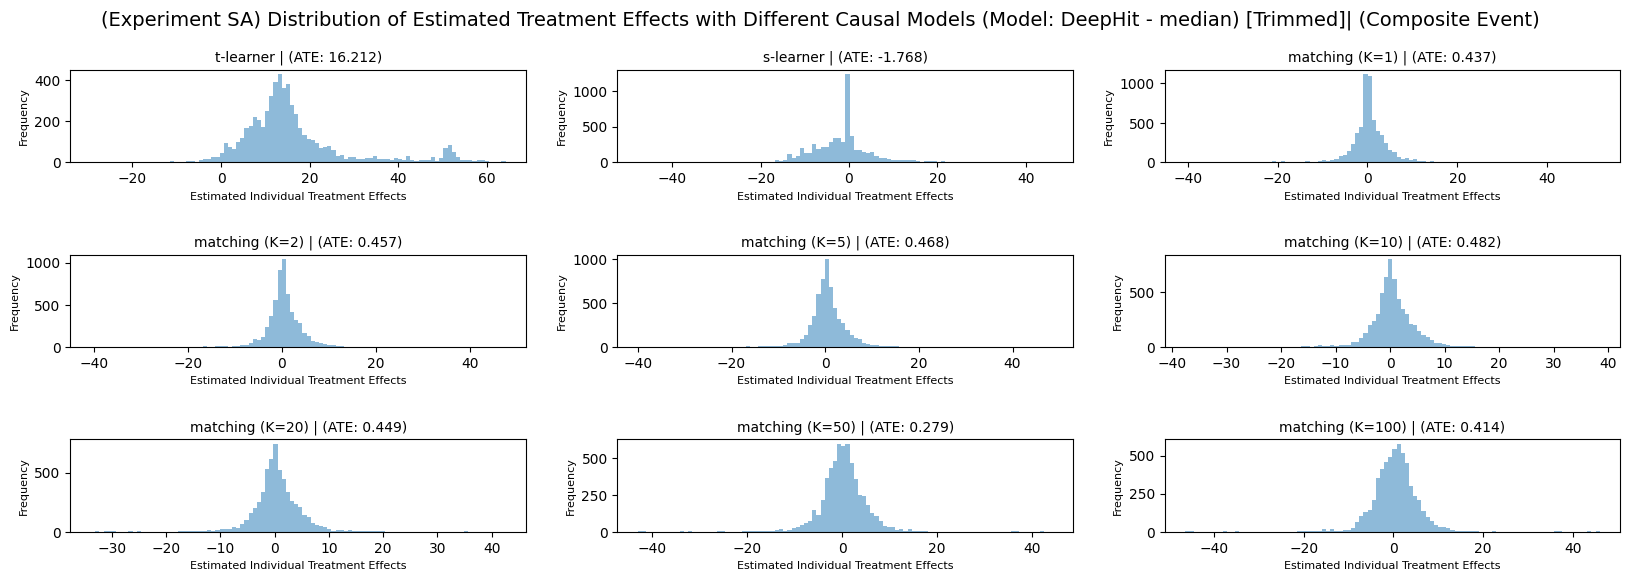

In [14]:
ML_models = [{"CoxPH": {}}, {"RandomSurvivalForest": {}}, {"DeepSurv": {}}, {"DeepHit": {}}]
handle_imbalance = True
num_matches_list = [1, 2, 5, 10, 20, 50, 100]

for ML_model in ML_models:
    print(f"Running Causal Inference with {list(ML_model.keys())[0]} ...")
    get_meta_learner_results(causal_data_dict_trimmed, ML_model, handle_imbalance, ['t-learner', 's-learner', 'matching'], num_matches_list, 
                            EXPERIMENT_NUM, EXPERIMENT_TYPE, 
                            task=EXPERIMENT_TASK, task_setup_dict={"metric": "median", "max_time": np.inf, "extrapolate_median": True},
                            is_trimmed=True, plot_results=True, print_results=False, verbose_output=False);
    print("="*100)

# Paper Unadjusted Survival Curves

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import pickle

import sys
from pathlib import Path
# Add the parent directory to the system path
sys.path.append(str(Path().resolve().parent))

from causal_meta_learners.causal_inference_modeling import *
from causal_meta_learners.experiment_setup import *
from causal_meta_learners.survival_models import *

In [3]:
HORIZON = 12 # months
NON_ADHERENCE_THRESHOLD = 1./3
MINIMUM_NUM_TIME_STEPS = 4
LOW_OCCURENCY_THRESHOLD = 2
EXPERIMENT_TASK = "survival"
EXPERIMENT_TYPE = "Composite Event"
EXPERIMENT_NUM = "SA"

with open('../data_splits/mental-health-full/people_dict_unfiltered_expanded.pickle', 'rb') as handle:
    people_dict = pickle.load(handle)


data_df = pd.read_csv('../data_generation/adherence_export_expanded.csv')

In [4]:
continuous_covariates_lst=['age', 
                           'predicted_PRO_MORTALITY_12MO', 'predicted_PRO_JAILSTAY_12MO', 'predicted_PRO_OVERDOSE_12MO',
                           'predicted_PRO_302_12MO', 'predicted_PRO_SHELTER_STAY_12MO']

patient_data = PatientData(people_dict, data_df, 
                           experiment_type=EXPERIMENT_TYPE,
                           task=EXPERIMENT_TASK, horizon=HORIZON, 
                           non_adherence_threshold=NON_ADHERENCE_THRESHOLD, 
                           minimum_num_time_steps=MINIMUM_NUM_TIME_STEPS, 
                           low_occurrency_threshold=LOW_OCCURENCY_THRESHOLD,
                           continuous_covariates_lst=continuous_covariates_lst)

causal_data_dict = patient_data.get_causal_data_setup_for_each_experiment(EXPERIMENT_NUM)

In [21]:
aa = causal_data_dict['Y']['total']

print(f'mean time of first event: {aa[aa[:, 1] == 1][:, 0].mean():.2f} months +/- {aa[aa[:, 1] == 1][:, 0].std():.2f}')
print(f'mean time of censoring: {aa[aa[:, 1] == 0][:, 0].mean():.2f} months +/- {aa[aa[:, 1] == 0][:, 0].std():.2f}')

mean time of first event: 25.20 months +/- 22.55
mean time of censoring: 62.63 months +/- 29.08


Treatment RMST: 53.13070007186078
Control RMST: 61.038175665061175


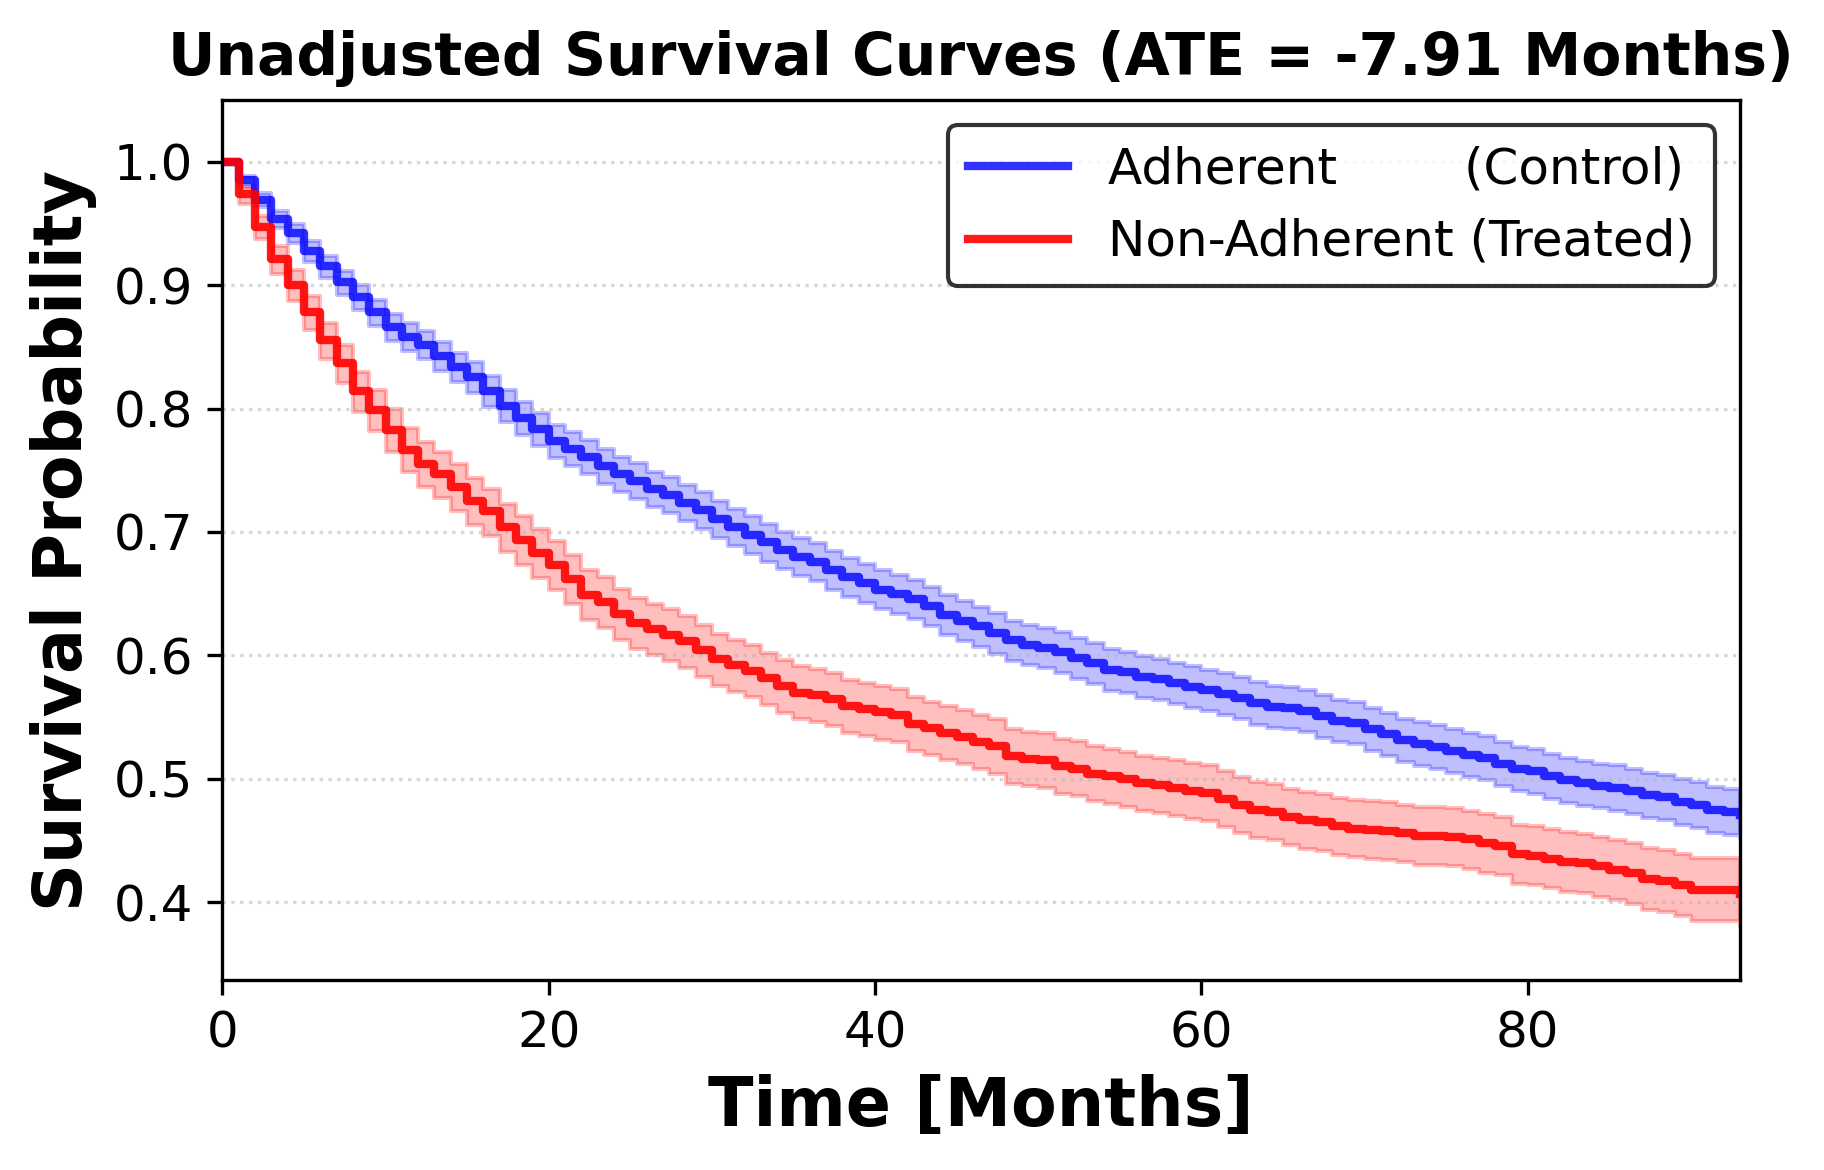

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

def get_unadjusted_survival_curve_paper_ready_plot(causal_data_dict):
    # Set font for publication-style consistency
    # plt.rcParams['font.family'] = 'Times New Roman'
    # plt.rcParams['font.size'] = 11

    survival_data_df = pd.DataFrame({
        'time': causal_data_dict['Y']['total'][:, 0], 
        'event': causal_data_dict['Y']['total'][:, 1],
        'treatment': causal_data_dict['A']['total']
    })

    kmf = KaplanMeierFitter()

    # Split into treatment and control groups
    treatment_group = survival_data_df[survival_data_df['treatment'] == 1]
    control_group = survival_data_df[survival_data_df['treatment'] == 0]

    # Set up figure with high resolution
    plt.figure(figsize=(6, 4), dpi=300)

    # Fit and plot Kaplan-Meier survival curves with improved aesthetics
    kmf.fit(durations=control_group['time'], event_observed=control_group['event'], label='Adherent        (Control)')
    ax = kmf.plot_survival_function(ci_show=True, linewidth=2, linestyle='-', color='blue', alpha=0.8)
    
    control_rmst = np.trapz(y=kmf.survival_function_.values.flatten(), x=kmf.survival_function_.index)

    kmf.fit(durations=treatment_group['time'], event_observed=treatment_group['event'], label='Non-Adherent (Treated)')
    kmf.plot_survival_function(ax=ax, ci_show=True, linewidth=2, linestyle='-', color='red', alpha=0.9)

    treatment_rmst = np.trapz(y=kmf.survival_function_.values.flatten(), x=kmf.survival_function_.index)

    # Dashed line for median survival time
    title_str = f"ATE = {treatment_rmst - control_rmst:.2f} Months"

    print(f"Treatment RMST: {treatment_rmst}")
    print(f"Control RMST: {control_rmst}")

    # Customize the plot with improved formatting
    plt.title(f"Unadjusted Survival Curves ({title_str})", fontsize=14, fontweight='bold')
    plt.xlabel("Time [Months]", fontsize=16, fontweight='bold')
    plt.ylabel("Survival Probability", fontsize=16, fontweight='bold')

    # Ensure proper axis scaling
    plt.ylim(min(kmf.survival_function_.values)-0.07, 1.05)
    plt.xlim(0, survival_data_df['time'].max())

    # Improve legend appearance
    plt.legend(fontsize=12, frameon=True, loc='best', edgecolor='black')

    # Subtle grid lines (horizontal only, for readability)
    plt.grid(axis='y', linestyle='dotted', alpha=0.5)

    # Adjust ticks for readability
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()
    # plt.savefig('unadjusted_survival_curves.pdf', dpi=300)

    plt.show()

# Call the function
get_unadjusted_survival_curve_paper_ready_plot(causal_data_dict)